<a href="https://colab.research.google.com/github/AxithChoudhary/Automatic_Ticket_Classification/blob/main/Automatic_Ticket_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Opening JSON file 
f = open("/content/drive/MyDrive/Upgrad dataset/complaints-2021-05-14_08_16.json")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [ ]:

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
df.isna().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [ ]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [ ]:

import re
#Assign new column names
df.columns=[re.sub('^_','',col) for col in df.columns]

df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [ ]:
#Assign nan in place of blanks in the complaints column
df.columns
df["complaint_what_happened"].replace("",np.nan,inplace=True)

In [ ]:
df["complaint_what_happened"]

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [ ]:
#Remove all rows where complaints column is nan
df.dropna(subset=["complaint_what_happened"],inplace=True)

In [ ]:
df["complaint_what_happened"]

1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
10       Chase Card was reported on XX/XX/2019. However...
11       On XX/XX/2018, while trying to book a XXXX  XX...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    After being a Chase Card customer for well ove...
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

In [ ]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleanText(text):
    text=text.lower()
    text=re.sub(r'\[.*?\]','',text)

    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)

    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

df['complaint_what_happened']= df['complaint_what_happened'].apply(lambda x: cleanText(x))

In [ ]:
import nltk
nltk.download("popular")
# pip install nltk

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [ ]:

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemma_texts(document):     
    lemmaList = []
    # document = nlp(document)
    lemmaList.append(lemmatizer.lemmatize(document))
    # for word in document:
    #     lemmaList.append(lemmatizer.lemmatize(word))
    return " ".join(lemmaList)

df["lemmatized_complaint"] =  df['complaint_what_happened'].apply(lambda x: lemma_texts(x))
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in xx/xx/ and was...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fr...",Information belongs to someone else,Consent provided,"chase card was reported on xx/xx/. however, fr..."
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ...",Information belongs to someone else,Consent provided,"on xx/xx/, while trying to book a xxxx xxxx ..."
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$.} i deposit ...


In [ ]:
df["lemmatized_complaint"].head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in xx/xx/ and was...
10    chase card was reported on xx/xx/. however, fr...
11    on xx/xx/, while trying to book a xxxx  xxxx  ...
14    my grand son give me check for {$.} i deposit ...
Name: lemmatized_complaint, dtype: object

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[['complaint_what_happened','lemmatized_complaint']]

In [ ]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,i upgraded my xxxx xxxx card in xx/xx/ and was...
10,"chase card was reported on xx/xx/. however, fr...","chase card was reported on xx/xx/. however, fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx/xx/, while trying to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give me check for {$.} i deposit ...


In [ ]:
#Write your function to extract the POS tags 
from textblob import TextBlob

def pos_tag(text):
  # write your code here
    text_blob = TextBlob(text)

    return ' '.join([ word for (word,pos) in text_blob.tags if pos == "NN"])

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1)  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,Unnamed: 0,Unnamed: 0.1,index,type,id,score,tags,zip_code,complaint_id,issue,...,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint,complaint_POS_removed
0,0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,...,Web,2019-05-01T12:00:00-05:00,NaN,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...
1,1,2,complaint-public-v2,complaint,3199379,0.0,NaN,77069,3199379,"Other features, terms, or problems",...,Web,2019-04-02T12:00:00-05:00,NaN,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in xx/xx/ and was...,i card agent upgrade date agent information or...
2,2,10,complaint-public-v2,complaint,3233499,0.0,NaN,104XX,3233499,Incorrect information on your report,...,Web,2019-05-06T12:00:00-05:00,NaN,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fr...",Information belongs to someone else,Consent provided,"chase card was reported on xx/xx/. however, fr...",card xx/xx/ application identity consent credi...
3,3,11,complaint-public-v2,complaint,3180294,0.0,NaN,750XX,3180294,Incorrect information on your report,...,Web,2019-03-15T12:00:00-05:00,NaN,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ...",Information belongs to someone else,Consent provided,"on xx/xx/, while trying to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...
4,4,14,complaint-public-v2,complaint,3224980,0.0,NaN,920XX,3224980,Managing an account,...,Web,2019-04-27T12:00:00-05:00,NaN,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$.} i deposit ...,son deposit chase account fund chase bank acco...


In [ ]:
df_clean.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'type', 'id', 'score', 'tags',
       'zip_code', 'complaint_id', 'issue', 'date_received', 'state',
       'consumer_disputed', 'product', 'company_response', 'company',
       'submitted_via', 'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely', 'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided', 'lemmatized_complaint',
       'complaint_POS_removed'],
      dtype='object')

In [ ]:
# df.to_csv('df.csv')
# df_clean.to_csv('df_clean.csv')
# !cp df.csv "/content/drive/MyDrive/Upgrad dataset/Automatic Ticket Classification"
# !cp df_clean.csv "/content/drive/MyDrive/Upgrad dataset/Automatic Ticket Classification"

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from google.colab import drive
drive.mount('/content/drive')

df=pd.read_csv("/content/drive/MyDrive/Upgrad dataset/Automatic Ticket Classification/df.csv")
df.head()

df_clean=pd.read_csv("/content/drive/MyDrive/Upgrad dataset/Automatic Ticket Classification/df_clean.csv")
df_clean.head()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Mounted at /content/drive


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,index,type,id,score,tags,zip_code,complaint_id,...,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint,complaint_POS_removed
0,0,0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,...,Web,2019-05-01T12:00:00-05:00,NaN,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...
1,1,1,2,complaint-public-v2,complaint,3199379,0.0,NaN,77069,3199379,...,Web,2019-04-02T12:00:00-05:00,NaN,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in xx/xx/ and was...,i card agent upgrade date agent information or...
2,2,2,10,complaint-public-v2,complaint,3233499,0.0,NaN,104XX,3233499,...,Web,2019-05-06T12:00:00-05:00,NaN,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fr...",Information belongs to someone else,Consent provided,"chase card was reported on xx/xx/. however, fr...",card xx/xx/ application identity consent credi...
3,3,3,11,complaint-public-v2,complaint,3180294,0.0,NaN,750XX,3180294,...,Web,2019-03-15T12:00:00-05:00,NaN,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ...",Information belongs to someone else,Consent provided,"on xx/xx/, while trying to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...
4,4,4,14,complaint-public-v2,complaint,3224980,0.0,NaN,920XX,3224980,...,Web,2019-04-27T12:00:00-05:00,NaN,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$.} i deposit ...,son deposit chase account fund chase bank acco...


In [2]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_len=[len(word) for word in df_clean["complaint_what_happened"]]
print(complaint_len[:10])

[482, 351, 220, 1470, 466, 29, 2265, 1392, 3528, 129]


Text(0, 0.5, 'No. of Complaints')

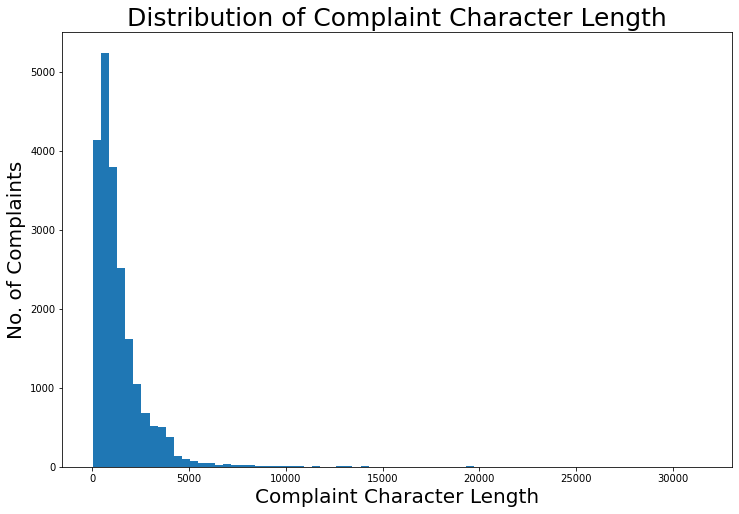

In [3]:
plt.figure(figsize=(12,8))
plt.hist(complaint_len,bins=75)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)

#### Find the top 40 words by frequency among all the articles after processing the text.

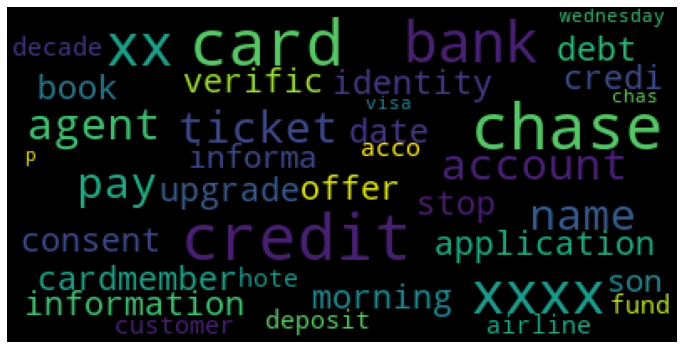

In [4]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud,STOPWORDS

stop_word=set(STOPWORDS)
word_cloud=WordCloud(
                          stopwords=stop_word,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42).generate(str(df_clean["complaint_POS_removed"]))

fig=plt.figure(figsize=(12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


In [5]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [6]:
df_clean["complaint_POS_removed"].head()

0    morning name stop bank cardmember debt verific...
1    i card agent upgrade date agent information or...
2    card xx/xx/ application identity consent credi...
3    book xxxx ticket i offer ticket card i informa...
4    son deposit chase account fund chase bank acco...
Name: complaint_POS_removed, dtype: object

In [7]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def n_gram(text,n=1,type="unigram",top=30):
  countVector=CountVectorizer(stop_words='english',ngram_range=(n,n)).fit(text)
  ngram=countVector.transform(text)
  count_values=ngram.sum(axis=0)
  vocab=[(word,count_values[0,idx]) for word,idx in countVector.vocabulary_.items()]
  df_ngram=pd.DataFrame(sorted(vocab,key=lambda x: x[1],reverse=True)).rename(columns={0:"frequence",1:type})
  return df_ngram[:top]

In [8]:
#Print the top 10 words in the unigram frequency
top_unigram_word=n_gram(df_clean["complaint_POS_removed"].values.astype('U'))
top_unigram_word.head(10)

,frequence,unigram
0,xxxx,63330
1,chase,54904
2,account,41446
3,xx,38614
4,credit,32743
5,bank,26710
6,card,26321
7,payment,14017
8,time,12021
9,money,11969


In [9]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_bigram_word=n_gram(df_clean["complaint_POS_removed"].values.astype('U'),2,"bigram")
top_bigram_word.head(30)

,frequence,bigram
0,xx xx,19277
1,xx xxxx,14155
2,credit card,11090
3,xxxx xxxx,10305
4,xxxx chase,3672
5,chase credit,3618
6,credit report,3281
7,chase account,3245
8,customer service,3026
9,account chase,3013


In [10]:
#Print the top 10 words in the bigram frequency
top_bigram_word.head(10)

,frequence,bigram
0,xx xx,19277
1,xx xxxx,14155
2,credit card,11090
3,xxxx xxxx,10305
4,xxxx chase,3672
5,chase credit,3618
6,credit report,3281
7,chase account,3245
8,customer service,3026
9,account chase,3013


In [11]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_trigram_word=n_gram(df_clean["complaint_POS_removed"].values.astype('U'),3,"trigram")
top_trigram_word.head(30)

,frequence,trigram
0,xx xx xxxx,13868
1,xxxx xxxx xxxx,2425
2,chase credit card,1998
3,xxxx xx xx,1961
4,xx xxxx chase,1140
5,account xx xx,1111
6,xx xxxx xx,863
7,credit card account,845
8,credit card company,819
9,chase xx xx,806


In [12]:
#Print the top 10 words in the trigram frequency
top_trigram_word.head(10)

,frequence,trigram
0,xx xx xxxx,13868
1,xxxx xxxx xxxx,2425
2,chase credit card,1998
3,xxxx xx xx,1961
4,xx xxxx chase,1140
5,account xx xx,1111
6,xx xxxx xx,863
7,credit card account,845
8,credit card company,819
9,chase xx xx,806


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [13]:
df_clean['Complaint_clean'] = df_clean["complaint_POS_removed"].str.replace('xxxx','')

In [14]:
#All masked texts has been removed
df_clean

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,index,type,id,score,tags,zip_code,complaint_id,...,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,0,0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,...,2019-05-01T12:00:00-05:00,NaN,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...
1,1,1,2,complaint-public-v2,complaint,3199379,0.0,NaN,77069,3199379,...,2019-04-02T12:00:00-05:00,NaN,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in xx/xx/ and was...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...
2,2,2,10,complaint-public-v2,complaint,3233499,0.0,NaN,104XX,3233499,...,2019-05-06T12:00:00-05:00,NaN,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fr...",Information belongs to someone else,Consent provided,"chase card was reported on xx/xx/. however, fr...",card xx/xx/ application identity consent credi...,card xx/xx/ application identity consent credi...
3,3,3,11,complaint-public-v2,complaint,3180294,0.0,NaN,750XX,3180294,...,2019-03-15T12:00:00-05:00,NaN,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ...",Information belongs to someone else,Consent provided,"on xx/xx/, while trying to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...
4,4,4,14,complaint-public-v2,complaint,3224980,0.0,NaN,920XX,3224980,...,2019-04-27T12:00:00-05:00,NaN,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$.} i deposit ...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,21067,21067,78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,...,2018-12-07T12:00:00-05:00,NaN,General-purpose credit card or charge card,Yes,after being a chase card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided,after being a chase card customer for well ove...,chase card customer decade credit airline hote...,chase card customer decade credit airline hote...
21068,21068,21068,78309,complaint-public-v2,complaint,3091984,0.0,NaN,934XX,3091984,...,2018-12-05T12:00:00-05:00,NaN,General-purpose credit card or charge card,Yes,"on wednesday, xx/xx/xxxx i called chas, my xxx...",Other problem,Consent provided,"on wednesday, xx/xx/xxxx i called chas, my xxx...",wednesday xx/xx/xxxx i chas visa credit card p...,wednesday xx/xx/ i chas visa credit card provi...
21069,21069,21069,78310,complaint-public-v2,complaint,3133355,0.0,NaN,923XX,3133355,...,2019-01-25T12:00:00-05:00,NaN,Checking account,Yes,i am not familiar with xxxx pay and did not un...,Transaction was not authorized,Consent provided,i am not familiar with xxxx pay and did not un...,i pay risk bank app chase mobile banking i mer...,i pay risk bank app chase mobile banking i mer...
21070,21070,21070,78311,complaint-public-v2,complaint,3110963,0.0,NaN,NaN,3110963,...,2018-12-27T12:00:00-05:00,NaN,General-purpose credit card or charge card,Yes,i have had flawless credit for yrs. i've had ...,Problem with balance transfer,Consent provided,i have had flawless credit for yrs. i've had ...,i credit yrs i credit chase freedom xxxx i bal...,i credit yrs i credit chase freedom i balance...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [15]:
#Write your code here to initialise the TfidfVectorizer 
tfidf=TfidfVectorizer(max_df=0.95, min_df=2,stop_words="english")


In [16]:
df_clean['Complaint_clean']

0        morning name stop bank cardmember debt verific...
1        i card agent upgrade date agent information or...
2        card xx/xx/ application identity consent credi...
3        book  ticket i offer ticket card i information...
4        son deposit chase account fund chase bank acco...
                               ...                        
21067    chase card customer decade credit airline hote...
21068    wednesday xx/xx/ i chas visa credit card provi...
21069    i pay risk bank app chase mobile banking i mer...
21070    i credit yrs i credit chase freedom  i balance...
21071    jp bank  order line credit i i account payment...
Name: Complaint_clean, Length: 21072, dtype: object

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [17]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidfMat=tfidf.fit_transform(df_clean['Complaint_clean'].values.astype("U"))

In [18]:
tfidfMat

<21072x6614 sparse matrix of type '<class 'numpy.float64'>'
	with 512868 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [19]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [82]:
# from gensim.corpora.dictionary import Dictionary
# from gensim.models.coherencemodel import CoherenceModel
# from operator import itemgetter

In [20]:
i=[x.split() for x in df_clean['Complaint_clean'].values.astype("U")]
print(i)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model =NMF(n_components=num_topics,init="random",random_state=40) #write your code here


# W=nmf_model.fit_transform(tfidfMat)
# H=nmf_model.components_

In [22]:
nmf_model.fit(tfidfMat)
len(tfidf.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



6614

In [23]:
#Print the Top15 words for each of the topics
words=np.array(tfidf.get_feature_names())
topic_words=pd.DataFrame(np.zeros((num_topics,15)),index=[f"Topic {i+1}" for i in range(num_topics)],columns=[f"Word {i+1}" for i in range(15)]).astype(str)

for i in range(num_topics):
  # ix=H[i].argsort()[::-1][:15]
  ix=nmf_model.components_[i].argsort()[::-1][:15]
  topic_words.iloc[i] = words[ix]

topic_words


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,chase,balance,checking,fee,branch,access,business,number,money,payment,reason,overdraft,customer,transfer
Topic 2,bank,check,money,claim,deposit,branch,transaction,fraud,cash,person,atm,number,day,chase,business
Topic 3,xx,chase,dispute,charge,letter,claim,date,refund,merchant,transaction,email,statement,payment,department,phone
Topic 4,loan,payment,mortgage,chase,home,modification,time,property,rate,month,foreclosure,house,sale,letter,escrow
Topic 5,credit,card,report,chase,inquiry,company,score,charge,information,balance,limit,fraud,debt,letter,application


In [24]:
topic_results = nmf_model.transform(tfidfMat)
topic_results.argmax(axis=1)

df_clean['Topic'] = topic_results.argmax(axis=1)
df_clean.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,index,type,id,score,tags,zip_code,complaint_id,...,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,0,0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,...,NaN,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,1
1,1,1,2,complaint-public-v2,complaint,3199379,0.0,NaN,77069,3199379,...,NaN,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in xx/xx/ and was...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,2
2,2,2,10,complaint-public-v2,complaint,3233499,0.0,NaN,104XX,3233499,...,NaN,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fr...",Information belongs to someone else,Consent provided,"chase card was reported on xx/xx/. however, fr...",card xx/xx/ application identity consent credi...,card xx/xx/ application identity consent credi...,2
3,3,3,11,complaint-public-v2,complaint,3180294,0.0,NaN,750XX,3180294,...,NaN,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ...",Information belongs to someone else,Consent provided,"on xx/xx/, while trying to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...,4
4,4,4,14,complaint-public-v2,complaint,3224980,0.0,NaN,920XX,3224980,...,NaN,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$.} i deposit ...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,1


In [25]:
First5_comp=df_clean.groupby('Topic').head(5)
First5_comp.sort_values('Topic')

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,index,type,id,score,tags,zip_code,complaint_id,...,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
12,12,12,27,complaint-public-v2,complaint,3200365,0.0,NaN,462XX,3200365,...,NaN,Checking account,Yes,i opened an account with chase bank on xxxx an...,Didn't receive terms that were advertised,Consent provided,i opened an account with chase bank on xxxx an...,i account bank xxxx code bonus i everything ac...,i account bank code bonus i everything accoun...,0
26,26,26,63,complaint-public-v2,complaint,3265950,0.0,Servicemember,333XX,3265950,...,NaN,Checking account,Yes,i tried to send almost {$.} at xxxx and the tr...,Deposits and withdrawals,Consent provided,i tried to send almost {$.} at xxxx and the tr...,i transaction id i service i refund card account,i transaction id i service i refund card account,0
18,18,18,43,complaint-public-v2,complaint,3264139,0.0,NaN,941XX,3264139,...,NaN,General-purpose credit card or charge card,Yes,chase sent me an email today with the innocuou...,Credit card company forcing arbitration,Consent provided,chase sent me an email today with the innocuou...,chase email today title information chase acco...,chase email today title information chase acco...,0
10,10,10,24,complaint-public-v2,complaint,3200018,0.0,NaN,112XX,3200018,...,NaN,Loan,Yes,mishandling of this account by chase auto and ...,Problem while selling or giving up the vehicle,Consent provided,mishandling of this account by chase auto and ...,mishandling account auto xxxx,mishandling account auto,0
6,6,6,17,complaint-public-v2,complaint,3331023,0.0,NaN,770XX,3331023,...,NaN,Checking account,Yes,with out notice j.p. morgan chase restricted m...,Funds not received from closed account,Consent provided,with out notice j.p. morgan chase restricted m...,j.p. chase account debit card tuesday i branch...,j.p. chase account debit card tuesday i branch...,0
16,16,16,40,complaint-public-v2,complaint,3357920,0.0,NaN,107XX,3357920,...,NaN,Checking account,Yes,"xxxx xxxx a sofa, love seat, table and chairs ...",Transaction was not authorized,Consent provided,"xxxx xxxx a sofa, love seat, table and chairs ...",xxxx sofa seat table debit card bank claim fur...,sofa seat table debit card bank claim furnitu...,1
13,13,13,30,complaint-public-v2,complaint,3235343,0.0,NaN,946XX,3235343,...,NaN,Checking account,Yes,"to whom it may concern, chase bank charged wro...",Overdrafts and overdraft fees,Consent provided,"to whom it may concern, chase bank charged wro...",concern chase bank balance fee balance order o...,concern chase bank balance fee balance order o...,1
8,8,8,21,complaint-public-v2,complaint,3226110,0.0,Servicemember,846XX,3226110,...,NaN,Domestic (US) money transfer,Yes,"on xxxx xx/xx/, i made a {$.} payment to an on...",NaN,Consent provided,"on xxxx xx/xx/, i made a {$.} payment to an on...",i payment retailer pay xxxx chase website i we...,i payment retailer pay chase website i websit...,1
0,0,0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,...,NaN,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,1
4,4,4,14,complaint-public-v2,complaint,3224980,0.0,NaN,920XX,3224980,...,NaN,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$.} i deposit ...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,1


In [89]:
# Bank Account services
# Credit card or prepaid card
# Theft/Dispute Reporting
# Mortgage/Loan
# Others

In [26]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic={0:"Other",1.0:"Theft/Dispute Reporting",2.0:"Bank Account services",3.0:"Mortgage/Loan",4.0:"Credit card or prepaid card"}

In [27]:
df_clean.dtypes

Unnamed: 0                     int64
Unnamed: 0.1                   int64
Unnamed: 0.1.1                 int64
index                         object
type                          object
id                             int64
score                        float64
tags                          object
zip_code                      object
complaint_id                   int64
issue                         object
date_received                 object
state                         object
consumer_disputed             object
product                       object
company_response              object
company                       object
submitted_via                 object
date_sent_to_company          object
company_public_response       object
sub_product                   object
timely                        object
complaint_what_happened       object
sub_issue                     object
consumer_consent_provided     object
lemmatized_complaint          object
complaint_POS_removed         object
C

In [28]:
df_clean[['sub_issue',"Topic"]]

,sub_issue,Topic
0,Didn't receive enough information to verify debt,1
1,Problem with rewards from credit card,2
2,Information belongs to someone else,2
3,Information belongs to someone else,4
4,Funds not handled or disbursed as instructed,1
...,...,...
21067,Didn't receive advertised or promotional terms,4
21068,Other problem,2
21069,Transaction was not authorized,1
21070,Problem with balance transfer,2


In [29]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,index,type,id,score,tags,zip_code,complaint_id,...,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
12,12,12,27,complaint-public-v2,complaint,3200365,0.0,NaN,462XX,3200365,...,NaN,Checking account,Yes,i opened an account with chase bank on xxxx an...,Didn't receive terms that were advertised,Consent provided,i opened an account with chase bank on xxxx an...,i account bank xxxx code bonus i everything ac...,i account bank code bonus i everything accoun...,0
26,26,26,63,complaint-public-v2,complaint,3265950,0.0,Servicemember,333XX,3265950,...,NaN,Checking account,Yes,i tried to send almost {$.} at xxxx and the tr...,Deposits and withdrawals,Consent provided,i tried to send almost {$.} at xxxx and the tr...,i transaction id i service i refund card account,i transaction id i service i refund card account,0
18,18,18,43,complaint-public-v2,complaint,3264139,0.0,NaN,941XX,3264139,...,NaN,General-purpose credit card or charge card,Yes,chase sent me an email today with the innocuou...,Credit card company forcing arbitration,Consent provided,chase sent me an email today with the innocuou...,chase email today title information chase acco...,chase email today title information chase acco...,0
10,10,10,24,complaint-public-v2,complaint,3200018,0.0,NaN,112XX,3200018,...,NaN,Loan,Yes,mishandling of this account by chase auto and ...,Problem while selling or giving up the vehicle,Consent provided,mishandling of this account by chase auto and ...,mishandling account auto xxxx,mishandling account auto,0
6,6,6,17,complaint-public-v2,complaint,3331023,0.0,NaN,770XX,3331023,...,NaN,Checking account,Yes,with out notice j.p. morgan chase restricted m...,Funds not received from closed account,Consent provided,with out notice j.p. morgan chase restricted m...,j.p. chase account debit card tuesday i branch...,j.p. chase account debit card tuesday i branch...,0
16,16,16,40,complaint-public-v2,complaint,3357920,0.0,NaN,107XX,3357920,...,NaN,Checking account,Yes,"xxxx xxxx a sofa, love seat, table and chairs ...",Transaction was not authorized,Consent provided,"xxxx xxxx a sofa, love seat, table and chairs ...",xxxx sofa seat table debit card bank claim fur...,sofa seat table debit card bank claim furnitu...,1
13,13,13,30,complaint-public-v2,complaint,3235343,0.0,NaN,946XX,3235343,...,NaN,Checking account,Yes,"to whom it may concern, chase bank charged wro...",Overdrafts and overdraft fees,Consent provided,"to whom it may concern, chase bank charged wro...",concern chase bank balance fee balance order o...,concern chase bank balance fee balance order o...,1
8,8,8,21,complaint-public-v2,complaint,3226110,0.0,Servicemember,846XX,3226110,...,NaN,Domestic (US) money transfer,Yes,"on xxxx xx/xx/, i made a {$.} payment to an on...",NaN,Consent provided,"on xxxx xx/xx/, i made a {$.} payment to an on...",i payment retailer pay xxxx chase website i we...,i payment retailer pay chase website i websit...,1
0,0,0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,...,NaN,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,1
4,4,4,14,complaint-public-v2,complaint,3224980,0.0,NaN,920XX,3224980,...,NaN,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$.} i deposit ...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [30]:
#Create the dictionary of Topic names and Topics
topic={0:"Other",1.0:"Theft/Dispute Reporting",2.0:"Bank Account services",3.0:"Mortgage/Loan",4.0:"Credit card or prepaid card"}
df_clean['Topic'] =df_clean['Topic'].map(topic) 

<ipython-input-30-443bd219440f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
# df_clean[['sub_issue',"Topic"]]
df_clean

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,index,type,id,score,tags,zip_code,complaint_id,...,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,0,0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,...,NaN,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,Theft/Dispute Reporting
1,1,1,2,complaint-public-v2,complaint,3199379,0.0,NaN,77069,3199379,...,NaN,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in xx/xx/ and was...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,Bank Account services
2,2,2,10,complaint-public-v2,complaint,3233499,0.0,NaN,104XX,3233499,...,NaN,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fr...",Information belongs to someone else,Consent provided,"chase card was reported on xx/xx/. however, fr...",card xx/xx/ application identity consent credi...,card xx/xx/ application identity consent credi...,Bank Account services
3,3,3,11,complaint-public-v2,complaint,3180294,0.0,NaN,750XX,3180294,...,NaN,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ...",Information belongs to someone else,Consent provided,"on xx/xx/, while trying to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...,Credit card or prepaid card
4,4,4,14,complaint-public-v2,complaint,3224980,0.0,NaN,920XX,3224980,...,NaN,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$.} i deposit ...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,Theft/Dispute Reporting
5,5,5,15,complaint-public-v2,complaint,3209411,0.0,NaN,NaN,3209411,...,NaN,Credit reporting,Yes,can you please remove inquiry,Credit inquiries on your report that you don't...,Consent provided,can you please remove inquiry,inquiry,inquiry,Credit card or prepaid card
6,6,6,17,complaint-public-v2,complaint,3331023,0.0,NaN,770XX,3331023,...,NaN,Checking account,Yes,with out notice j.p. morgan chase restricted m...,Funds not received from closed account,Consent provided,with out notice j.p. morgan chase restricted m...,j.p. chase account debit card tuesday i branch...,j.p. chase account debit card tuesday i branch...,Other
7,7,7,20,complaint-public-v2,complaint,3352857,0.0,NaN,207XX,3352857,...,NaN,Loan,Yes,"during the summer months, i experience a decli...",Denied request to lower payments,Consent provided,"during the summer months, i experience a decli...",summer income employment month payment extensi...,summer income employment month payment extensi...,Mortgage/Loan
8,8,8,21,complaint-public-v2,complaint,3226110,0.0,Servicemember,846XX,3226110,...,NaN,Domestic (US) money transfer,Yes,"on xxxx xx/xx/, i made a {$.} payment to an on...",NaN,Consent provided,"on xxxx xx/xx/, i made a {$.} payment to an on...",i payment retailer pay xxxx chase website i we...,i payment retailer pay chase website i websit...,Theft/Dispute Reporting
9,9,9,23,complaint-public-v2,complaint,3237765,0.0,NaN,330XX,3237765,...,NaN,General-purpose credit card or charge card,Yes,i have a chase credit card which is incorrectl...,Account information incorrect,Consent provided,i have a chase credit card which is incorrectl...,chase credit card credit report company issue,chase credit card credit report company issue,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [96]:
#Create the dictionary again of Topic names and Topics
# topic={0:"Other",1.0:"Theft/Dispute Reporting",2.0:"Bank Account services",3.0:"Mortgage/Loan",4.0:"Credit card or prepaid card"}
# df_clean['Topic'] =df_clean['Topic'].map(topic) 

In [32]:
df_clean

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,index,type,id,score,tags,zip_code,complaint_id,...,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,0,0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,...,NaN,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,Theft/Dispute Reporting
1,1,1,2,complaint-public-v2,complaint,3199379,0.0,NaN,77069,3199379,...,NaN,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in xx/xx/ and was...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,Bank Account services
2,2,2,10,complaint-public-v2,complaint,3233499,0.0,NaN,104XX,3233499,...,NaN,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fr...",Information belongs to someone else,Consent provided,"chase card was reported on xx/xx/. however, fr...",card xx/xx/ application identity consent credi...,card xx/xx/ application identity consent credi...,Bank Account services
3,3,3,11,complaint-public-v2,complaint,3180294,0.0,NaN,750XX,3180294,...,NaN,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ...",Information belongs to someone else,Consent provided,"on xx/xx/, while trying to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...,Credit card or prepaid card
4,4,4,14,complaint-public-v2,complaint,3224980,0.0,NaN,920XX,3224980,...,NaN,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$.} i deposit ...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,Theft/Dispute Reporting
5,5,5,15,complaint-public-v2,complaint,3209411,0.0,NaN,NaN,3209411,...,NaN,Credit reporting,Yes,can you please remove inquiry,Credit inquiries on your report that you don't...,Consent provided,can you please remove inquiry,inquiry,inquiry,Credit card or prepaid card
6,6,6,17,complaint-public-v2,complaint,3331023,0.0,NaN,770XX,3331023,...,NaN,Checking account,Yes,with out notice j.p. morgan chase restricted m...,Funds not received from closed account,Consent provided,with out notice j.p. morgan chase restricted m...,j.p. chase account debit card tuesday i branch...,j.p. chase account debit card tuesday i branch...,Other
7,7,7,20,complaint-public-v2,complaint,3352857,0.0,NaN,207XX,3352857,...,NaN,Loan,Yes,"during the summer months, i experience a decli...",Denied request to lower payments,Consent provided,"during the summer months, i experience a decli...",summer income employment month payment extensi...,summer income employment month payment extensi...,Mortgage/Loan
8,8,8,21,complaint-public-v2,complaint,3226110,0.0,Servicemember,846XX,3226110,...,NaN,Domestic (US) money transfer,Yes,"on xxxx xx/xx/, i made a {$.} payment to an on...",NaN,Consent provided,"on xxxx xx/xx/, i made a {$.} payment to an on...",i payment retailer pay xxxx chase website i we...,i payment retailer pay chase website i websit...,Theft/Dispute Reporting
9,9,9,23,complaint-public-v2,complaint,3237765,0.0,NaN,330XX,3237765,...,NaN,General-purpose credit card or charge card,Yes,i have a chase credit card which is incorrectl...,Account information incorrect,Consent provided,i have a chase credit card which is incorrectl...,chase credit card credit report company issue,chase credit card credit report company issue,Credit card or prepaid card


In [33]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

In [34]:
training_data

,complaint_what_happened,Topic
0,good morning my name is xxxx xxxx and i apprec...,Theft/Dispute Reporting
1,i upgraded my xxxx xxxx card in xx/xx/ and was...,Bank Account services
2,"chase card was reported on xx/xx/. however, fr...",Bank Account services
3,"on xx/xx/, while trying to book a xxxx xxxx ...",Credit card or prepaid card
4,my grand son give me check for {$.} i deposit ...,Theft/Dispute Reporting
5,can you please remove inquiry,Credit card or prepaid card
6,with out notice j.p. morgan chase restricted m...,Other
7,"during the summer months, i experience a decli...",Mortgage/Loan
8,"on xxxx xx/xx/, i made a {$.} payment to an on...",Theft/Dispute Reporting
9,i have a chase credit card which is incorrectl...,Credit card or prepaid card


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [35]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code to get the Vector count
count_vec=CountVectorizer()
X_train_counts=count_vec.fit_transform(training_data["complaint_what_happened"])
print(count_vec.vocabulary_)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


{'good': 329, 'morning': 476, 'my': 480, 'name': 482, 'is': 398, 'xxxx': 860, 'and': 48, 'appreciate': 59, 'it': 400, 'if': 363, 'you': 865, 'could': 185, 'help': 346, 'me': 448, 'put': 586, 'stop': 719, 'to': 769, 'chase': 146, 'bank': 93, 'cardmember': 129, 'services': 683, 'in': 367, 'wrote': 858, 'asking': 67, 'for': 301, 'debt': 203, 'verification': 818, 'what': 837, 'they': 755, 'sent': 681, 'statement': 712, 'which': 839, 'not': 494, 'acceptable': 4, 'am': 44, 'the': 747, 'validate': 814, 'instead': 390, 'been': 99, 'receiving': 599, 'mail': 435, 'every': 264, 'month': 472, 'from': 311, 'them': 749, 'attempting': 79, 'collect': 161, 'have': 343, 'right': 652, 'know': 409, 'this': 758, 'information': 376, 'as': 64, 'consumer': 176, 'account': 9, 'thanks': 744, 'advance': 23, 'your': 866, 'upgraded': 806, 'card': 128, 'xx': 859, 'was': 829, 'told': 771, 'by': 119, 'agent': 32, 'who': 841, 'did': 220, 'upgrade': 805, 'anniversary': 49, 'date': 198, 'would': 853, 'change': 138, 'tur

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_train_tfidf,training_data.Topic,test_size=0.25,random_state=42)


In [37]:
# print(X_train)
print(X_train.shape)

(18, 867)


In [38]:
print(y_train)
print(y_train.shape)

1           Bank Account services
33                  Mortgage/Loan
5     Credit card or prepaid card
2           Bank Account services
12                          Other
15          Bank Account services
3     Credit card or prepaid card
4         Theft/Dispute Reporting
23                  Mortgage/Loan
18                          Other
26                          Other
19          Bank Account services
47                  Mortgage/Loan
7                   Mortgage/Loan
10                          Other
14    Credit card or prepaid card
20          Bank Account services
6                           Other
Name: Topic, dtype: object
(18,)


##Logistic regression

In [39]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression 
lr=LogisticRegression().fit(X_train,y_train)
lpredict=lr.predict(X_test)

from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(y_test, lpredict))


Accuracy :  0.0


##Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier
dc=DecisionTreeClassifier().fit(X_train,y_train)
dpredict=dc.predict(X_test)

print ("Accuracy : ", accuracy_score(y_test, dpredict))


Accuracy :  0.2857142857142857


##Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth=5)
rfm=rf.fit(X_train,y_train)
rfpredict=rf.predict(X_test)
print ("Accuracy : ", accuracy_score(y_test, rfpredict))

Accuracy :  0.14285714285714285


##Naive Bayes

In [42]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print ("Accuracy : ", accuracy_score(y_test, rfpredict))

Accuracy :  0.14285714285714285
